## Importando librerias

In [64]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from collections import OrderedDict
import numpy as np
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Configuracion de Variables

In [65]:
# Coloca aquí la ruta a tu modelo .pth (el checkpoint de Lightning)
PATH_MODELO_SSL = "/lustre/proyectos/p032/models/multi_pretext_model2.ckpt"
MODEL_PATH = "models/221025MG_backbone.ssl.pth"

# Apunta al directorio raíz que contiene las carpetas Training y Testing
DATASET='/lustre/home/jreyes/MEDA_Challenge/compartido/datasets/braindataset' 
PATH_DATASET = "/lustre/home/jreyes/MEDA_Challenge/compartido/datasets/braindataset" 

# Define el número de clases de tu dataset (Glioma, Meningioma, Notumor, Pituitary)
NUM_CLASES = 4

# Parámetros para el modelo y entrenamiento
BATCH_SIZE = 8
EPOCHS_DE_PRUEBA = 100
LEARNING_RATE = 0.0001
JIGSAW_N = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Semilla para reproducibilidad en la división del dataset.
SEED = 27

# Define las proporciones del split del dataset
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 1.0 - TRAIN_RATIO - VAL_RATIO 

# Para Hacer Few Shot Learning
K_SHOTS = 200

## Importación del Modelo SSL

In [66]:
class MultiPretextSSL_Lightning(pl.LightningModule):
    def __init__(self, backbone, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters('learning_rate') # Guarda lr
        self.backbone = backbone
        self.lr = learning_rate
        
        num_features = 512 # Salida de ResNet18
        
        # --- DECODER CORREGIDO PARA 28x28 ---
        decoder_layers_28x28 = [
            nn.ConvTranspose2d(num_features, 256, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1), # 4x4 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 14x14 -> 28x28
            nn.Sigmoid()
        ]
        
        self.color_head = nn.Sequential(*decoder_layers_28x28)
        self.patch_head = nn.Sequential(*decoder_layers_28x28)
        
        # --- JIGSAW HEAD CORREGIDO PARA N=4 (16 patches) ---
        self.n_patches = JIGSAW_N * JIGSAW_N # 16
        self.jigsaw_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_patches * self.n_patches) # 16*16 = 256
        )

    def forward(self, x, task="color"):
        feats = self.backbone(x)
        if task == "color":
            return self.color_head(feats)
        elif task == "patch":
            return self.patch_head(feats)
        elif task == "jigsaw":
            return self.jigsaw_head(feats)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

class MoCoLightning(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder_q = nn.Sequential(backbone)

resnet = models.resnet18(weights=None) 
# Tu backbone (quitando la capa FC final)
backbone_structure = nn.Sequential(*list(resnet.children())[:-1])

# Cargar el estado
encoder_wrapper = MoCoLightning(backbone=backbone_structure)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Cargar los pesos en la estructura
encoder_wrapper.encoder_q[0].load_state_dict(state_dict)

# --- Este es tu backbone listo para usar ---
ssl_backbone = encoder_wrapper.encoder_q[0].to(DEVICE)
print("Backbone cargado y movido a GPU.")
model = MultiPretextSSL_Lightning.load_from_checkpoint(PATH_MODELO_SSL, backbone=ssl_backbone)

# Congelar todo el backbone
for param in model.backbone.parameters():
    param.requires_grad = False

in_features = 512  # ResNet18 sin FC tiene 512 features

Backbone cargado y movido a GPU.


## Creacion de Dataset

In [67]:
data_transform = transforms.Compose([
    transforms.Resize(224),               # redimensiona la imagen
    transforms.CenterCrop(224),           # recorta el centro
    transforms.ToTensor(),                # convierte a tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # normalización ImageNet
                         std=[0.229, 0.224, 0.225])
])

# --- NUEVA LÓGICA DE CARGA DE DATOS ---

# Definir las rutas a las carpetas Training y Testing
PATH_TRAIN_DATA = f"{PATH_DATASET}/Training"
PATH_TEST_DATA = f"{PATH_DATASET}/Testing"

# Definir la proporción para dividir la data de Training en train/validation
# El notebook original usaba 0.7 (Train) y 0.1 (Val).
# Mantenemos esa proporción (7:1) para el nuevo split: 7 / (7 + 1) = 0.875
TRAIN_VAL_SPLIT_RATIO = 0.875

try:
    # 1. Cargar el dataset de ENTRENAMIENTO (fuente para train y val)
    #    LO LLAMAMOS 'full_dataset' para que la celda de Few-Shot (FSL) funcione sin cambios.
    full_dataset = ImageFolder(PATH_TRAIN_DATA, transform=data_transform)
    print(f"Dataset de Training/Validation cargado desde: {PATH_TRAIN_DATA}")
    print(f"Total de imágenes de Training/Validation: {len(full_dataset)}")
    
    # 2. Cargar el dataset de TESTEO
    test_dataset = ImageFolder(PATH_TEST_DATA, transform=data_transform)
    print(f"Dataset de Testeo cargado desde: {PATH_TEST_DATA}")
    print(f"Total de imágenes de Testeo: {len(test_dataset)}")
    print(f"Clases encontradas: {full_dataset.classes}")

    # 3. Validar el número de clases
    if len(full_dataset.classes) != NUM_CLASES:
        print(f"¡Advertencia! Se esperaban {NUM_CLASES} clases pero se encontraron {len(full_dataset.classes)} carpetas.")
        NUM_CLASES = len(full_dataset.classes)
        print(f"NUM_CLASES actualizado a {NUM_CLASES}")
    
    # 4. Obtener etiquetas e índices SOLO del set de entrenamiento (full_dataset)
    targets = full_dataset.targets
    indices = list(range(len(targets)))

    # 5. Dividir 'full_dataset' (que es la carpeta 'Training') en train y validation
    #    Estas variables (train_indices, train_targets) son necesarias para la celda FSL
    train_indices, val_indices, train_targets, val_targets = train_test_split(
        indices,
        targets,
        train_size=TRAIN_VAL_SPLIT_RATIO,
        stratify=targets, 
        random_state=SEED
    )

    print(f"Dividiendo datos de Training (estratificado): {len(train_indices)} (Train) y {len(val_indices)} (Val)")

    # 6. Crear Datasets de Subset para train y val (basados en full_dataset)
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    # 'test_dataset' ya se cargó directamente desde la carpeta 'Testing'

    # 7. Cargando los DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"DataLoaders creados. Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

except FileNotFoundError as e:
    print(f"Error: No se encontró el directorio {e.filename}")
    print("Asegúrate de que 'PATH_DATASET' apunte al directorio que contiene las carpetas 'Training' y 'Testing'.")
    raise

Dataset de Training/Validation cargado desde: /lustre/home/jreyes/MEDA_Challenge/compartido/datasets/braindataset/Training
Total de imágenes de Training/Validation: 5712
Dataset de Testeo cargado desde: /lustre/home/jreyes/MEDA_Challenge/compartido/datasets/braindataset/Testing
Total de imágenes de Testeo: 1311
Clases encontradas: ['glioma', 'meningioma', 'notumor', 'pituitary']
Dividiendo datos de Training (estratificado): 4998 (Train) y 714 (Val)
DataLoaders creados. Train: 4998, Val: 714, Test: 1311


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Creando el dataset para FSL

In [68]:

print(f"Creando un Support Set de {K_SHOTS}-shot a partir de los {len(train_indices)} datos de entrenamiento...")


train_targets_np = np.array(train_targets)
train_indices_np = np.array(train_indices) # Índices que apuntan a full_dataset

classes = np.unique(train_targets_np)
n_classes = len(classes)

# 3. Recolectar los índices originales (de full_dataset) para nuestro support set
support_indices = []
for c in classes:
    # 4. Encontrar los índices (dentro de train_indices_np) que pertenecen a la clase 'c'
    class_mask = (train_targets_np == c)
    
    # 5. Obtener los índices *originales* (de full_dataset) para esa clase
    all_indices_for_class_in_train = train_indices_np[class_mask]
    
    # 6. Seleccionar K_SHOTS al azar
    if len(all_indices_for_class_in_train) < K_SHOTS:
        print(f"¡Advertencia! Clase {c} solo tiene {len(all_indices_for_class_in_train)} muestras en el set de entto. Usando todas.")
        k_shot_indices = all_indices_for_class_in_train
    else:
        # Selecciona K índices al azar (sin reemplazo) de este grupo
        k_shot_indices = np.random.choice(all_indices_for_class_in_train, K_SHOTS, replace=False)
        
    support_indices.extend(k_shot_indices)

print(f"Total de muestras en el Support Set: {len(support_indices)} ({n_classes} clases * {K_SHOTS} shots)")

# 7. Crear el nuevo Dataset y DataLoader "Few-Shot"
#    OJO: Se crea a partir de `full_dataset` usando los índices que seleccionamos
few_shot_dataset = Subset(full_dataset, support_indices)

# 8. ¡Este es el DataLoader que usarás en tu bucle de entrenamiento!
few_shot_train_loader = DataLoader(
    few_shot_dataset,
    batch_size=BATCH_SIZE, # Puedes usar el mismo BATCH_SIZE o uno más pequeño
    shuffle=True,          # ¡Importante barajar tu pequeño set!
    num_workers=2
)

print(f"DataLoader Few-Shot ('few_shot_train_loader') creado con {len(few_shot_dataset)} imágenes.")
print("--------------------------------------------------------")

Creando un Support Set de 200-shot a partir de los 4998 datos de entrenamiento...
Total de muestras en el Support Set: 800 (4 clases * 200 shots)
DataLoader Few-Shot ('few_shot_train_loader') creado con 800 imágenes.
--------------------------------------------------------


## Creando Cabezal de Clasificación

In [69]:
class LinearProbingModel(nn.Module):
    def __init__(self, backbone, linear_head):
        super().__init__()
        self.backbone = backbone
        self.linear_head = linear_head

    def forward(self, x):
        feats = self.backbone(x)           
        feats = feats.view(feats.size(0), -1)  
        out = self.linear_head(feats)      
        return out
    

linear_head = nn.Linear(in_features, NUM_CLASES)
model = LinearProbingModel(model.backbone, linear_head).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.linear_head.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)


## Entrenamiento de Cabezal y haciendo Few Shot Learning

In [70]:
print("Iniciando entrenamiento de la cabeza lineal (Few Shot learning)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    # ... (El código de entrenamiento es idéntico) ...
    model.train() 
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in few_shot_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(few_shot_train_loader.dataset)

    # ---- Validación ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

print("Entrenamiento de la cabeza finalizado.")

# --- 6. EVALUAR EL RENDIMIENTO ---
# CAMBIADO: Mensaje para reflejar la división estratificada
print("Evaluando en el set de testeo (división estratificada)...")

model.eval() 
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# --- RESULTADO FINAL ---
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy:.2f} %")
print("========================================================")

Iniciando entrenamiento de la cabeza lineal (Few Shot learning)...
Epoch 1/100 - Train Loss: 1.3451 - Val Loss: 1.3079 - Val Acc: 49.86%
Epoch 2/100 - Train Loss: 1.3080 - Val Loss: 1.2646 - Val Acc: 52.38%
Epoch 3/100 - Train Loss: 1.2803 - Val Loss: 1.2350 - Val Acc: 55.18%
Epoch 4/100 - Train Loss: 1.2438 - Val Loss: 1.1972 - Val Acc: 57.56%
Epoch 5/100 - Train Loss: 1.2260 - Val Loss: 1.1754 - Val Acc: 57.56%
Epoch 6/100 - Train Loss: 1.2092 - Val Loss: 1.1568 - Val Acc: 54.48%
Epoch 7/100 - Train Loss: 1.1908 - Val Loss: 1.1390 - Val Acc: 55.88%
Epoch 8/100 - Train Loss: 1.1671 - Val Loss: 1.1201 - Val Acc: 57.28%
Epoch 9/100 - Train Loss: 1.1532 - Val Loss: 1.0913 - Val Acc: 59.24%
Epoch 10/100 - Train Loss: 1.1434 - Val Loss: 1.0821 - Val Acc: 60.78%
Epoch 11/100 - Train Loss: 1.1141 - Val Loss: 1.0696 - Val Acc: 60.92%
Epoch 12/100 - Train Loss: 1.1204 - Val Loss: 1.0398 - Val Acc: 61.06%
Epoch 13/100 - Train Loss: 1.0943 - Val Loss: 1.0486 - Val Acc: 58.82%
Epoch 14/100 - Trai

## Matriz de Clasificacion


Generando matriz de confusión para las clases: ['glioma', 'meningioma', 'notumor', 'pituitary']


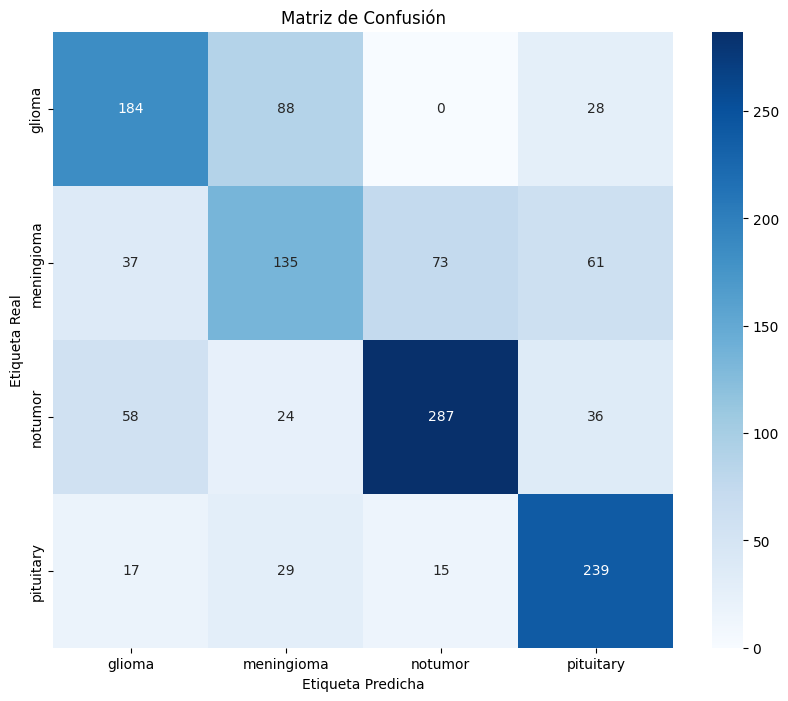

In [71]:

class_names = full_dataset.classes
print(f"\nGenerando matriz de confusión para las clases: {class_names}")

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

## Resnet 18


In [72]:
print("\n" + "="*50)
print(" 🚀 INICIANDO EXPERIMENTO 1: ResNet-18 🚀")
print("="*50)

# 1. Cargar modelo ResNet-18 pre-entrenado
model_18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 2. Congelar todas las capas del backbone
for param in model_18.parameters():
    param.requires_grad = False

# 3. Reemplazar la cabeza (capa 'fc')
#    La nueva capa 'fc' tendrá requires_grad=True por defecto
in_features_18 = model_18.fc.in_features
model_18.fc = nn.Linear(in_features_18, NUM_CLASES)

# 4. Mover modelo al DEVICE
model_18 = model_18.to(DEVICE)

# 5. Crear optimizador (SOLO para los parámetros de la nueva cabeza)
optimizer_18 = optim.Adam(filter(lambda p: p.requires_grad, model_18.parameters()), lr=LEARNING_RATE)

# --- Bucle de Entrenamiento (Tu código) ---
print("Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-18)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    model_18.train() 
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in few_shot_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer_18.zero_grad()
        outputs = model_18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_18.step()
        running_loss += loss.item() * inputs.size(0)
    
    # ¡CORRECCIÓN AQUÍ!
    # Usamos el tamaño del dataset few-shot, no el 'train_loader' original
    epoch_loss = running_loss / len(few_shot_train_loader.dataset)

    # ---- Validación ----
    model_18.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model_18(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

print("Entrenamiento de la cabeza (ResNet-18) finalizado.")

# --- Evaluación (ResNet-18) ---
print("Evaluando ResNet-18 en el set de testeo...")
model_18.eval() 
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy_18 = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de ResNet-18 completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy_18:.2f} %")
print("========================================================")


 🚀 INICIANDO EXPERIMENTO 1: ResNet-18 🚀
Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-18)...


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/100 - Train Loss: 1.3778 - Val Loss: 1.2445 - Val Acc: 43.70%
Epoch 2/100 - Train Loss: 1.2153 - Val Loss: 1.0739 - Val Acc: 62.04%
Epoch 3/100 - Train Loss: 1.0854 - Val Loss: 0.9649 - Val Acc: 68.07%
Epoch 4/100 - Train Loss: 0.9997 - Val Loss: 0.8579 - Val Acc: 73.81%
Epoch 5/100 - Train Loss: 0.9106 - Val Loss: 0.7993 - Val Acc: 77.73%
Epoch 6/100 - Train Loss: 0.8663 - Val Loss: 0.7266 - Val Acc: 79.13%
Epoch 7/100 - Train Loss: 0.8452 - Val Loss: 0.6873 - Val Acc: 81.51%
Epoch 8/100 - Train Loss: 0.7765 - Val Loss: 0.6378 - Val Acc: 82.07%
Epoch 9/100 - Train Loss: 0.7308 - Val Loss: 0.6395 - Val Acc: 80.95%
Epoch 10/100 - Train Loss: 0.7353 - Val Loss: 0.5871 - Val Acc: 83.61%
Epoch 11/100 - Train Loss: 0.7101 - Val Loss: 0.5669 - Val Acc: 83.33%
Epoch 12/100 - Train Loss: 0.6647 - Val Loss: 0.5533 - Val Acc: 82.07%
Epoch 13/100 - Train Loss: 0.6426 - Val Loss: 0.5272 - Val Acc: 83.19%
Epoch 14/100 - Train Loss: 0.6373 - Val Loss: 0.5175 - Val Acc: 84.73%
Epoch 15/100 - 

## Resnet 50

In [ ]:
print("\n" + "="*50)
print(" 🚀 INICIANDO EXPERIMENTO 2: ResNet-50 🚀")
print("="*50)

in_features = model.backbone(torch.randn(1,3,224,224).to(DEVICE)).view(1,-1).size(1)


# 1. Cargar modelo ResNet-50 pre-entrenado
model_50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# 2. Congelar todas las capas del backbone
for param in model_50.parameters():
    param.requires_grad = False

# 3. Reemplazar la cabeza (capa 'fc')
in_features_50 = model_50.fc.in_features
model_50.fc = nn.Linear(in_features_50, NUM_CLASES)

# 4. Mover modelo al DEVICE
model_50 = model_50.to(DEVICE)

# 5. Crear optimizador (SOLO para los parámetros de la nueva cabeza)
optimizer_50 = optim.Adam(filter(lambda p: p.requires_grad, model_50.parameters()), lr=LEARNING_RATE)

# --- Bucle de Entrenamiento (Tu código) ---
print("Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-50)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    model_50.train() 
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in few_shot_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer_50.zero_grad()
        outputs = model_50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_50.step()
        running_loss += loss.item() * inputs.size(0)
    
    # ¡CORRECCIÓN AQUÍ!
    epoch_loss = running_loss / len(few_shot_train_loader.dataset)

    # ---- Validación ----
    model_50.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model_50(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

print("Entrenamiento de la cabeza (ResNet-50) finalizado.")

# --- Evaluación (ResNet-50) ---
print("Evaluando ResNet-50 en el set de testeo...")
model_50.eval() 
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model_50(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy_50 = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de ResNet-50 completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy_50:.2f} %")
print("========================================================")


 🚀 INICIANDO EXPERIMENTO 2: ResNet-50 🚀
Iniciando entrenamiento de la cabeza lineal (Few Shot / ResNet-50)...
Epoch 1/100 - Train Loss: 1.3179 - Val Loss: 1.2482 - Val Acc: 66.39%
Epoch 2/100 - Train Loss: 1.1978 - Val Loss: 1.1306 - Val Acc: 76.19%
Epoch 3/100 - Train Loss: 1.0983 - Val Loss: 1.0337 - Val Acc: 79.27%
Epoch 4/100 - Train Loss: 1.0240 - Val Loss: 0.9774 - Val Acc: 81.79%
Epoch 5/100 - Train Loss: 0.9563 - Val Loss: 0.9098 - Val Acc: 81.37%
Epoch 6/100 - Train Loss: 0.8963 - Val Loss: 0.8687 - Val Acc: 81.37%
Epoch 7/100 - Train Loss: 0.8449 - Val Loss: 0.7920 - Val Acc: 84.45%
Epoch 8/100 - Train Loss: 0.8097 - Val Loss: 0.7617 - Val Acc: 83.47%
Epoch 9/100 - Train Loss: 0.7804 - Val Loss: 0.7214 - Val Acc: 83.75%
Epoch 10/100 - Train Loss: 0.7484 - Val Loss: 0.7079 - Val Acc: 84.03%
Epoch 11/100 - Train Loss: 0.7128 - Val Loss: 0.6831 - Val Acc: 85.71%
Epoch 12/100 - Train Loss: 0.6899 - Val Loss: 0.6406 - Val Acc: 86.69%
Epoch 13/100 - Train Loss: 0.6781 - Val Loss: 